In [382]:
import torch.nn as nn
import torch.nn.functional as F

In [383]:
import torch
import torchvision.models as models

# Load pretrained backbone (e.g., ResNet50)
backbone = models.resnet50(pretrained=True)

# Save the pretrained weights
torch.save(backbone.state_dict(), 'pretrained_backbone.pth')

In [384]:
backbone_features = torch.nn.Sequential(*(list(backbone.children())[:-2]))

In [385]:
list(backbone.children())[-4:]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [386]:
import torch

def diou_loss(preds, targets):
    """
    Calculate DIoU loss between prediction and target boxes.
    
    Args...
        preds... Predicted bounding boxes in format (x, y, width, height)
        targets... Target bounding boxes in format (x, y, width, height)
        
    Returns...
        DIoU loss value
    """
    # Convert (x, y, width, height) to (x1, y1, x2, y2)
    pred_x1 = preds[..., 0] - preds[..., 2] / 2
    pred_y1 = preds[..., 1] - preds[..., 3] / 2
    pred_x2 = preds[..., 0] + preds[..., 2] / 2
    pred_y2 = preds[..., 1] + preds[..., 3] / 2
    
    target_x1 = targets[..., 0] - targets[..., 2] / 2
    target_y1 = targets[..., 1] - targets[..., 3] / 2
    target_x2 = targets[..., 0] + targets[..., 2] / 2
    target_y2 = targets[..., 1] + targets[..., 3] / 2
    
    # Calculate intersection area
    x1 = torch.max(pred_x1, target_x1)
    y1 = torch.max(pred_y1, target_y1)
    x2 = torch.min(pred_x2, target_x2)
    y2 = torch.min(pred_y2, target_y2)
    
    intersection = torch.clamp((x2 - x1), min=0) * torch.clamp((y2 - y1), min=0)
    
    # Calculate union area
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    target_area = (target_x2 - target_x1) * (target_y2 - target_y1)
    union = pred_area + target_area - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)
    
    # Calculate the smallest enclosing box
    c_x1 = torch.min(pred_x1, target_x1)
    c_y1 = torch.min(pred_y1, target_y1)
    c_x2 = torch.max(pred_x2, target_x2)
    c_y2 = torch.max(pred_y2, target_y2)
    
    # Calculate the diagonal distance of the smallest enclosing box
    c_diag = torch.pow(c_x2 - c_x1, 2) + torch.pow(c_y2 - c_y1, 2)
    
    # Calculate the Euclidean distance between centers
    center_dist = torch.pow(preds[..., 0] - targets[..., 0], 2) + torch.pow(preds[..., 1] - targets[..., 1], 2)
    
    # Calculate DIoU
    diou = iou - center_dist / (c_diag + 1e-7)
    
    # Return DIoU loss
    return (1 - diou).mean()

In [387]:


# class IoULoss(nn.Module):
#     def __init__(self):
#         super(IoULoss, self).__init__()

#     def forward(self, pred, target):
#         return bbox_iou(pred, target).mean()
    
class DIoULoss(nn.Module):
    def __init__(self):
        super(DIoULoss, self).__init__()

    def forward(self, pred, target):
        return diou_loss(pred, target)



In [388]:

import torch
import torch.nn as nn
import numpy as np
 
 
class SIoU(nn.Module):
    # SIoU Loss https://arxiv.org/pdf/2205.12740.pdf
   def __init__(self, x1y1x2y2=False, eps=1e-7):
     super(SIoU, self).__init__()
     self.x1y1x2y2 = x1y1x2y2
     self.eps = eps
 
 
         
   def forward(self, box1, box2):
 
 
       # Get the coordinates of bounding boxes
       if self.x1y1x2y2:  # x1, y1, x2, y2 = box1
           b1_x1, b1_y1, b1_x2, b1_y2 = box1[0], box1[1], box1[2], box1[3]
           b2_x1, b2_y1, b2_x2, b2_y2 = box2[0], box2[1], box2[2], box2[3]
       else:  # transform from xywh to xyxy
           b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
           b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
           b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
           b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2
 
 
       # Intersection area
       inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
               (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
 
 
       # Union Area
       w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + self.eps
       w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + self.eps
       union = w1 * h1 + w2 * h2 - inter + self.eps
 
       # IoU value of the bounding boxes
       iou = inter / union
       cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
       ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
       s_cw = (b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5
       s_ch = (b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5
       sigma = torch.pow(s_cw ** 2 + s_ch ** 2, 0.5) + self.eps
       sin_alpha_1 = torch.abs(s_cw) / sigma
       sin_alpha_2 = torch.abs(s_ch) / sigma
       threshold = pow(2, 0.5) / 2
       sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)
        
       # Angle Cost
       angle_cost = 1 - 2 * torch.pow( torch.sin(torch.arcsin(sin_alpha) - np.pi/4), 2)
        
       # Distance Cost
       rho_x = (s_cw / (cw + self.eps)) ** 2
       rho_y = (s_ch / (ch + self.eps)) ** 2
       gamma = 2 - angle_cost
       distance_cost = 2 - torch.exp(gamma * rho_x) - torch.exp(gamma * rho_y)
        
       # Shape Cost
       omiga_w = torch.abs(w1 - w2) / torch.max(w1, w2)
       omiga_h = torch.abs(h1 - h2) / torch.max(h1, h2)
       shape_cost = torch.pow(1 - torch.exp(-1 * omiga_w), 4) + torch.pow(1 - torch.exp(-1 * omiga_h), 4)
       return (1 - (iou + 0.5 * (distance_cost + shape_cost))).mean()

In [389]:
# class SingleFaceRegressionHead(nn.Module):
#     def __init__(self, in_channels, hidden_dim=256):
#         super(SingleFaceRegressionHead, self).__init__()
        
#         # Feature processing
#         self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
#         self.act1 = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)
#         self.act2 = nn.ReLU(inplace=True)
#         self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)
#         self.act3 = nn.ReLU(inplace=True)
#         self.conv4 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)
#         self.act4 = nn.ReLU(inplace=True)
        
        
#         # Global average pooling to collapse spatial dimensions
#         self.global_pool = nn.AdaptiveAvgPool2d(1)
        
#         # Final regression layer for single bbox
#         self.l0 = nn.Linear(hidden_dim, 1024)  # [x, y, w, h]
#         self.act5 = nn.ReLU(inplace=True)
#         self.bbox_reg = nn.Linear(1024, 4)  # [x, y, w, h]
        
#         self._initialize_weights()
    
#     def forward(self, x):
#         # Process features
#         x = self.act1(self.conv1(x))
#         x = self.act2(self.conv2(x))
#         x = self.act3(self.conv3(x))
#         x = self.act4(self.conv4(x))

#         # Global pooling to get a single feature vector
#         x = self.global_pool(x)

#         # x = x.view(x.size(0), -1)  # Flatten: [batch_size, hidden_dim]
#         # print(x.shape)
#         # x = torch.flatten(x, start_dim=2)        
#         # print(x.shape)
#         # Output a single bounding box per image
#         x = x.squeeze()
#         x = self.act5(self.l0(x))  # Shape: [batch_size, 4]
#         bbox = self.bbox_reg(x)  # Shape: [batch_size, 4]
        
#         return bbox
    
#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.normal_(m.weight, std=0.01)
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, std=0.01)
#                 nn.init.constant_(m.bias, 0)

In [390]:
class RPNStyleRegressionHead(nn.Module):
    """
    A regression head inspired by Faster R-CNN's Region Proposal Network.
    Designed to predict bounding box coordinates for face detection.
    """
    def __init__(self, in_channels, intermediate_channels=512, num_anchors=9):
        super(RPNStyleRegressionHead, self).__init__()
        
        self.num_anchors = num_anchors  # Number of anchors per location
        
        # Shared intermediate convolutional layer (3x3 conv as in Faster R-CNN)
        self.conv = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, padding=1)
        
        # Regression layer for bounding box coordinates (x, y, w, h)
        # Each anchor produces 4 coordinates
        self.bbox_pred = nn.Conv2d(intermediate_channels, num_anchors * 4, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        # Weight initialization is important for training stability
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, std=0.01)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # Apply shared convolutional layer
        x = F.relu(self.conv(x))
        
        # Apply bounding box regression layer
        bbox_deltas = self.bbox_pred(x)
        
        # Reshape output for easier processing
        # From [batch_size, num_anchors*4, height, width] to [batch_size, height, width, num_anchors*4]
        bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).contiguous()
        
        # Reshape to [batch_size, height*width*num_anchors, 4]
        batch_size = bbox_deltas.size(0)
        bbox_deltas = bbox_deltas.view(batch_size, -1, 4)
        
        return bbox_deltas


class FaceDetector(nn.Module):
    def __init__(self, backbone_features, num_anchors=9):
        super(FaceDetector, self).__init__()
        self.backbone = backbone_features
        
        # Replace the simple regression head with our RPN-style head
        self.regression_head = RPNStyleRegressionHead(2048, 512, num_anchors)
        
        # Anchor generation parameters
        self.anchor_scales = [8, 16, 32]
        self.anchor_ratios = [0.5, 1, 2]
    
    def forward(self, x):
        # Extract features from backbone
        features = self.backbone(x)
        
        # Get bounding box predictions from regression head
        bbox_deltas = self.regression_head(features)
        
        # Generate anchors based on feature map size (during inference)
        if not self.training:
            # Get feature map dimensions
            _, _, feat_h, feat_w = features.size()
            
            # Generate anchors
            anchors = self._generate_anchors(feat_h, feat_w, x.device)
            
            # Apply deltas to anchors to get final predictions
            bbox_pred = self._apply_deltas_to_anchors(anchors, bbox_deltas)
            
            return bbox_pred
        
        return bbox_deltas
    
    def _generate_anchors(self, feat_h, feat_w, device):
        """
        Generate anchors for the given feature map size.
        """
        # Base anchor size (interpreted as the size of anchor with scale=1, ratio=1)
        base_size = 16
        
        # Generate all combinations of scales and ratios
        anchors = []
        for scale in self.anchor_scales:
            for ratio in self.anchor_ratios:
                h = base_size * scale * math.sqrt(1.0 / ratio)
                w = base_size * scale * math.sqrt(ratio)
                
                # Center coordinates (0, 0) - will be shifted later
                anchors.append([-w/2, -h/2, w/2, h/2])
        
        anchors = torch.tensor(anchors, device=device)
        
        # Create shifts based on feature map size
        shift_x = torch.arange(0, feat_w, device=device) * base_size
        shift_y = torch.arange(0, feat_h, device=device) * base_size
        
        shift_y, shift_x = torch.meshgrid(shift_y, shift_x)
        shift_x = shift_x.reshape(-1)
        shift_y = shift_y.reshape(-1)
        
        # Create 4-element shifts (for x1, y1, x2, y2)
        shifts = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1)
        
        # Apply shifts to all anchors
        # shifts shape: [feat_h*feat_w, 4]
        # anchors shape: [num_anchors, 4]
        k = shifts.shape[0]  # number of feature map locations
        a = anchors.shape[0]  # number of anchors per location
        
        # Reshape for broadcasting
        # [k, a, 4]
        all_anchors = (shifts.view(k, 1, 4) + anchors.view(1, a, 4)).reshape(-1, 4)
        
        return all_anchors
    
    def _apply_deltas_to_anchors(self, anchors, deltas):
        """
        Apply predicted deltas to anchors to get final box coordinates.
        
        deltas: [batch_size, num_anchors, 4]
        anchors: [num_anchors, 4]
        """
        # Get anchor dimensions
        widths = anchors[:, 2] - anchors[:, 0]
        heights = anchors[:, 3] - anchors[:, 1]
        ctr_x = anchors[:, 0] + 0.5 * widths
        ctr_y = anchors[:, 1] + 0.5 * heights
        
        # Unpack deltas
        dx = deltas[:, :, 0]
        dy = deltas[:, :, 1]
        dw = deltas[:, :, 2]
        dh = deltas[:, :, 3]
        
        # Apply deltas
        pred_ctr_x = dx * widths.unsqueeze(0) + ctr_x.unsqueeze(0)
        pred_ctr_y = dy * heights.unsqueeze(0) + ctr_y.unsqueeze(0)
        pred_w = torch.exp(dw) * widths.unsqueeze(0)
        pred_h = torch.exp(dh) * heights.unsqueeze(0)
        
        # Convert to x1, y1, x2, y2 format
        pred_x1 = pred_ctr_x - 0.5 * pred_w
        pred_y1 = pred_ctr_y - 0.5 * pred_h
        pred_x2 = pred_ctr_x + 0.5 * pred_w
        pred_y2 = pred_ctr_y + 0.5 * pred_h
        
        # Stack predictions
        pred_boxes = torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=2)
        
        return pred_boxes

In [391]:
# class FaceDetector(nn.Module):
#     def __init__(self, backbone_features):
#         super(FaceDetector, self).__init__()
#         self.backbone = backbone_features
        
#         self.regression_head = SingleFaceRegressionHead(2048,2048)

#     def forward(self, x):
#         features = self.backbone(x)
#         bbox_pred = self.regression_head(features)
        
#         return bbox_pred

In [392]:
from tqdm import tqdm
import os
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [393]:
train_path = '/home/kuba/Documents/data/raw/single-face-tensors/train'
test_path = '/home/kuba/Documents/data/raw/single-face-tensors/test'


In [394]:
imgs, bboxs = [], []
for file in tqdm(sorted(os.listdir(train_path))):
    X, y = torch.load(f'{train_path}/{file}')
    imgs.append(X)
    bboxs.append(y)

X, y = torch.stack(imgs), torch.stack(bboxs)

 27%|██▋       | 1590/5791 [00:00<00:01, 4033.95it/s]

100%|██████████| 5791/5791 [00:02<00:00, 2691.47it/s]


In [395]:
train_dataset = TensorDataset(X,y)

In [396]:
imgs, bboxs = [], []
for file in tqdm(sorted(os.listdir(test_path))):
    X, y = torch.load(f'{test_path}/{file}')
    imgs.append(X)
    bboxs.append(y)

X, y = torch.stack(imgs), torch.stack(bboxs)
test_dataset = TensorDataset(X,y)


100%|██████████| 1469/1469 [00:00<00:00, 3740.38it/s]


In [397]:
train_loader = DataLoader(train_dataset, batch_size=512)
test_loader = DataLoader(test_dataset, batch_size=512)


In [398]:
model = FaceDetector(backbone_features)
# model.load_state_dict(torch.load('/home/kuba/projects/swvl/testposttrain/outputmodel.pt', weights_only=True))

In [399]:
#lets freeze the weights in the backbone
for param in model.backbone.parameters():
    param.requires_grad = False


In [404]:
# optimizer = torch.optim.Adam(model.regression_head.parameters(), lr=0.001)

optimizer = torch.optim.Adam(model.regression_head.parameters(), lr=0.001)
criterion = SIoU()

In [412]:
lossi = []
devlossi = []

In [414]:
device = 'cuda:0'
model = model.to(device)

100%|██████████| 15/15 [01:39<00:00,  6.63s/it]


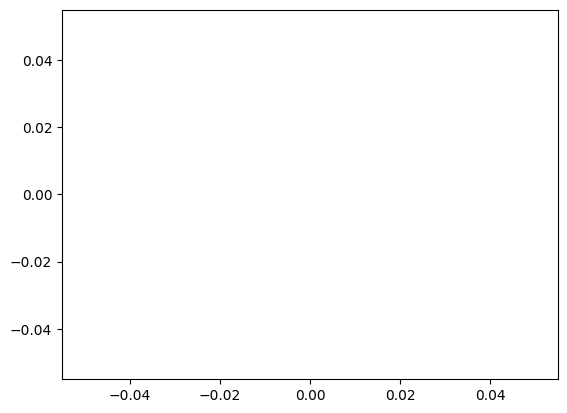

In [415]:
for epoch in tqdm(range(15)):

    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        
    lossi.append(loss_total / len(train_loader))

    loss_dev = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss_dev += loss.item()

    devlossi.append(loss_dev / len(test_loader))


plt.plot(lossi)
plt.plot(devlossi)

In [410]:
min(lossi)

1.4122824668884277

In [ ]:
for group in optimizer.param_groups:
    group['lr'] = 0.00003


In [408]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

In [409]:
img_num = 65

model_cpu = model.cpu()
logits = (model_cpu(X_batch[img_num].cpu().unsqueeze(dim=0))).squeeze()
visualize_prediction(X_batch[img_num].cpu(), logits.cpu(), 'N/A')
visualize_prediction(X_batch[img_num].cpu(), y_batch[img_num].cpu(), 'N/A')

criterion(logits,y_batch[img_num].cpu()).item()



ValueError: only one element tensors can be converted to Python scalars

In [ ]:
# torch.save(model.state_dict(), "bestt01.pt")

In [ ]:
X_me00 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_side.pt')
X_me01 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/clear_straighton.pt')
X_me02 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun_hand.pt')
X_me03 = torch.load('/home/kuba/Documents/data/raw/me-img/tensor/sun.pt')

me_full = torch.stack((X_me00,X_me01, X_me02, X_me03))

In [ ]:
me_full.shape

torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1174726..2.476566].


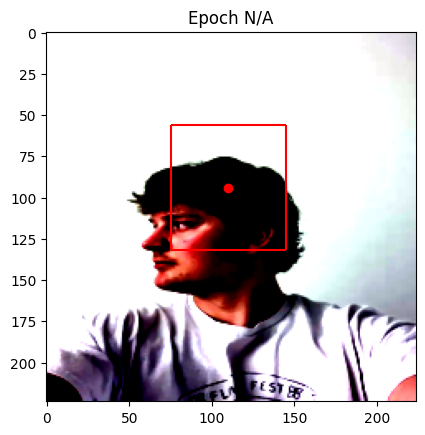

In [ ]:
model_cpu = model.cpu()
logits = (model_cpu(me_full[0].unsqueeze(dim=0))).squeeze()
visualize_prediction(me_full[0].cpu(), logits.cpu(), 'N/A')
